### Instructions
This notebook runs all the modelling and saves them as pickle files
IMPORTANT: Make sure you have pandas >= 1.5.0 in order to read in the pickle files

1. Run first cell and function definition cells

In [47]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb

features_all = pd.read_csv('features_all_weeks.csv')
features_all.drop(columns = ['Unnamed: 0', 'X1', 'X'], inplace = True)
# display(features_all)
print(features_all.info())

unclean_train_df = features_all[features_all['week'] != 8]
unclean_test_df = features_all[features_all['week'] == 8]

unclean_train_df.drop(columns = ['week'], inplace = True)
unclean_test_df.drop(columns = ['week'], inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200118 entries, 0 to 200117
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   playId                 200118 non-null  int64  
 1   gameId                 200118 non-null  int64  
 2   frameId                200118 non-null  int64  
 3   area_block             200118 non-null  float64
 4   dist_block             200118 non-null  float64
 5   dist_to_qb_block       200118 non-null  float64
 6   x_force_block          200118 non-null  float64
 7   y_force_block          200118 non-null  float64
 8   norm_weighted_x_block  200118 non-null  float64
 9   norm_weighted_y_block  200118 non-null  float64
 10  area_rush              200118 non-null  float64
 11  dist_rush              200118 non-null  float64
 12  dist_to_qb_rush        200118 non-null  float64
 13  x_force_rush           200118 non-null  float64
 14  y_force_rush           200118 non-nu

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
def get_features(df, features = 'all', response = 'bad_thing'):
    """
    Gets relevant features depending on what we want to use for modelling.
    There are 2 types of features: distance features and force features. 
    Force features can also be decomposed to simple forces, weighted forces, and partitioned forces
    TODO: missing net forces
    """
    y = df['bad_thing']
    x = df.drop(columns = ['bad_thing', 'hit', 'hurry', 'sack', 'playId', 'gameId', 'frameId'])
    if features == 'all':
        return (x, y)
    elif features == 'distance':
        x = x[['area_block', 'dist_block', 'dist_to_qb_block', 'area_rush', 'dist_rush', 'dist_to_qb_rush']]
    
    elif features == 'force_simple':
        x = x[['x_force_block', 'y_force_block', 'x_force_rush', 'y_force_rush']]
    
    elif features == 'force_weighted':
        x = x[['norm_weighted_x_block', 'norm_weighted_y_block', 'norm_weighted_x_rush', 'norm_weighted_y_rush']]
    
    elif features == 'force_partitioned':
        x = x[['net_x_force_bottom', 'net_y_force_bottom', 'net_x_force_middle', 'net_y_force_middle', 
               'net_x_force_top', 'net_y_force_top']]
    elif features == 'force_all':
        x = x.drop(columns = ['area_block', 'dist_block', 'dist_to_qb_block', 'area_rush', 'dist_rush', 'dist_to_qb_rush'])
    
    return (x, y)

# keep track of frameID
def df_split_by_frame(df, group_by = 5, features = 'all'):
    """
    Helper function to get separate dataframes for each frameID. Also keeps track of which set of features we're using
    for naming the model later on
    """
    df_grouped = df.groupby('frameId')
    df_dict = dict()

    for n, df in df_grouped:
        if (n % group_by == 1 and n < 60):
            x, y = get_features(df, features)
            # display(x)
            df_dict[n] = (x, y, features)
            # df_list.append((n, x, y))
    return df_dict

In [92]:

def train_rf_model(df_dict):
    models = dict()
    for (frameID, (x, y, features_str)) in df_dict.items():
        print(frameID)
        rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456, max_depth = 15)
        rf.fit(x, y)
        models[frameID] = (rf, features_str)
        del rf
    pickle.dump(models, open(f"model_list_rf_{features_str}.pkl", "wb"))
    return models

def train_xgboost_model(df_dict):
    models = dict()
    for (frameID, (x, y, features_str)) in df_dict.items():
        print(frameID)
        xgboost = xgb.XGBClassifier(max_depth=5, n_estimators=30,objective='binary:logistic')
        xgboost.fit(x, y)
        models[frameID] = (xgboost, features_str)
        del xgboost
    pickle.dump(models, open(f"model_list_xgboost_{features_str}.pkl", "wb"))
    return models

def train_lr_model(df_dict):
    models = dict()
    for (frameID, (x, y, features_str)) in df_dict.items():
        # TODO: change to LR model with intercept
        lr = sklearn.linear_model.LogisticRegression(fit_intercept=True)
        #fit intercept=Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
        lr.fit(x, y)
        models[frameID] = (lr, features_str)
        del lr
    pickle.dump(models, open(f"model_list_lr_{features_str}.pkl", "wb"))
    return models

def rf_xgboost_evaluate(test_df_dict, models,oob):
    for frameID, (model, _) in models.items():
        x, y, _ = test_df_dict[frameID]
        pred = model.predict(x)
        pred_prob = model.predict_proba(x)[:, 1]
        accuracy = accuracy_score(y, pred)
        recall = recall_score(y, pred)
        
        if oob==False:
            print(f'{frameID}: Out-of-bag score estimate: {model.oob_score_:.3}')
            
        print(f'{frameID}: Mean accuracy score: {accuracy:.3}')
        print(f'{frameID}: Recall: {recall:.3}')
        
        fpr, tpr, _ = roc_curve(y, pred_prob)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        p, r, thresh = precision_recall_curve(y, pred_prob)
        #print(thresh)
        fig, ax = plt.subplots()
        ax.plot(r, p, color='purple')

        #add axis labels to plot
        ax.set_title('Precision-Recall Curve')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')

        #display plot
        plt.show()
        
def lr_evaluate(test_df_dict, models):
    for frameID, (model, _) in models.items():
        x, y, _ = test_df_dict[frameID]
        pred = model.predict(x)
        pred_prob = model.predict_proba(x)[:, 1]
        lst1=np.array(pred_prob)
        pred=np.array(lst1>0.5).astype(int)
        accuracy = accuracy_score(y, pred)
        recall = recall_score(y, pred)
        
        print(f'{frameID}: Mean accuracy score: {accuracy:.3}')
        print(f'{frameID}: Recall: {recall:.3}')
        
        fpr, tpr, _ = roc_curve(y, pred_prob)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        p, r, thresh = precision_recall_curve(y, pred_prob)
        print("len : ",len(p))
        #print(thresh)
        fig, ax = plt.subplots()
        ax.plot(r, p, color='purple')

        #add axis labels to plot
        ax.set_title('Precision-Recall Curve')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')

        #display plot
        plt.show()
        


In [58]:
lst=[0.3,0.5,0.7]
res=[]
for item in lst:
    if item>0.5:
        res.append(1)
    else:
        res.append(0)
print(res)
lst1=np.array(lst)
res1=np.array(lst1>0.5).astype(int)
print(res1)
    


[0, 0, 1]
[0 0 1]


In [68]:
#features = 'distance'

#features = 'force_simple'
#features = 'force_weighted'
features = 'force_partitioned'



clean_train_df_dict = df_split_by_frame(unclean_train_df, features = features)
clean_test_df_dict = df_split_by_frame(unclean_test_df, features = features)

pickle.dump(clean_test_df_dict, open(f"clean_test_dict_{features}.pkl", "wb"))




# pickle.dump(models, open("model_list_all_features.pkl", "wb"))

In [59]:
models = train_rf_model(clean_train_df_dict)
models_force_simple = pickle.load(open("model_list_rf_force_simple.pkl", "rb"))
clean_test_df_dict_force_simple = pickle.load(open("clean_test_dict_force_simple.pkl", "rb"))
models_force_dist = pickle.load(open("model_list_rf_distance.pkl", "rb"))
#clean_test_df_dict_dist = pickle.load(open("clean_test_dict_distance.pkl", "rb"))

# models_all = pickle.load(open("model_list_all_features.pkl", "rb"))

In [81]:
rf_xgboost_evaluate(clean_test_df_dict_force_simple, models_force_simple,False)

ValueError: X has 6 features per sample; expecting 4

In [82]:
rf_xgboost_evaluate(clean_test_df_dict_dist, models_force_dist,False)

AttributeError: 'XGBClassifier' object has no attribute 'oob_score_'

In [93]:
features = 'distance'

#features = 'force_simple'
#features= all 



clean_train_df_dict = df_split_by_frame(unclean_train_df, features = features)
clean_test_df_dict = df_split_by_frame(unclean_test_df, features = features)

pickle.dump(clean_test_df_dict, open(f"clean_test_dict_{features}.pkl", "wb"))




# pickle.dump(models, open("model_list_all_features.pkl", "wb"))
models = train_lr_model(clean_train_df_dict)
models_force_distance = pickle.load(open("model_list_lr_distance.pkl", "rb"))
clean_test_df_dict_force_simple = pickle.load(open("clean_test_dict_distance.pkl", "rb"))
models_force_dist = pickle.load(open("model_list_lr_distance.pkl", "rb"))
# pickle.dump(models, open("model_list_all_features.pkl", "wb"))

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

1: Mean accuracy score: 0.616
1: Recall: 0.00285


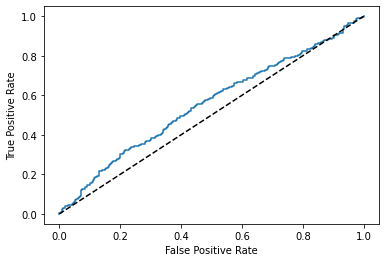

len :  914


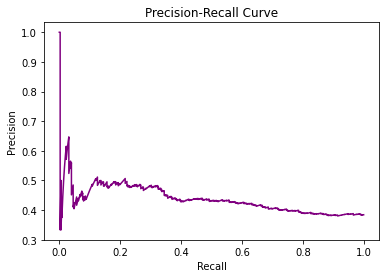

6: Mean accuracy score: 0.624
6: Recall: 0.0027


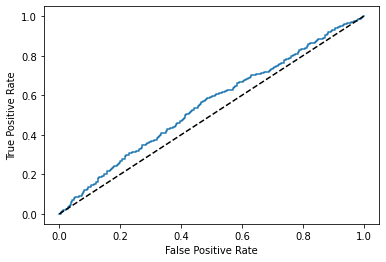

len :  990


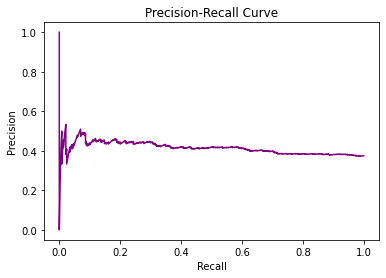

11: Mean accuracy score: 0.622
11: Recall: 0.0


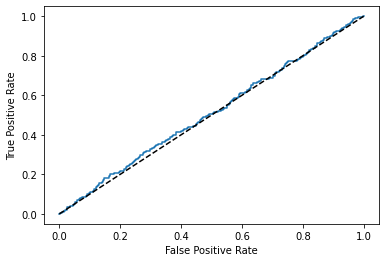

len :  969


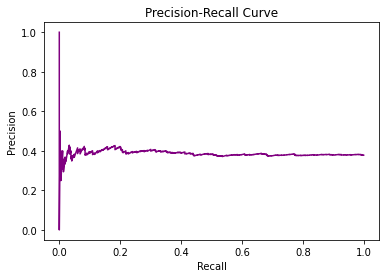

16: Mean accuracy score: 0.618
16: Recall: 0.0271


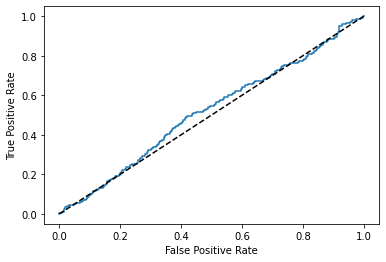

len :  872


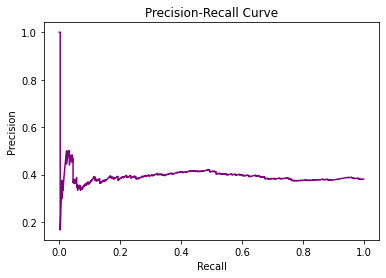

21: Mean accuracy score: 0.621
21: Recall: 0.0954


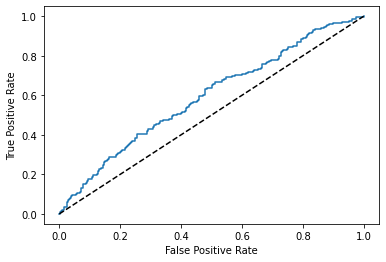

len :  621


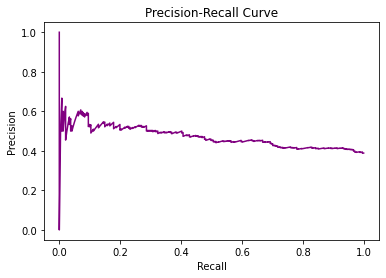

26: Mean accuracy score: 0.646
26: Recall: 0.223


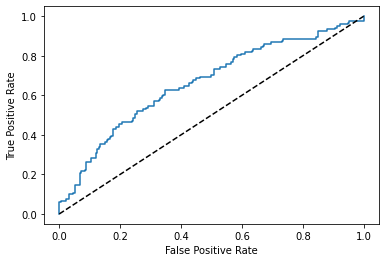

len :  315


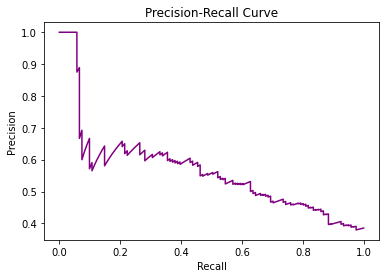

31: Mean accuracy score: 0.658
31: Recall: 0.639


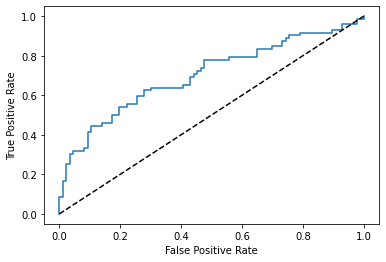

len :  159


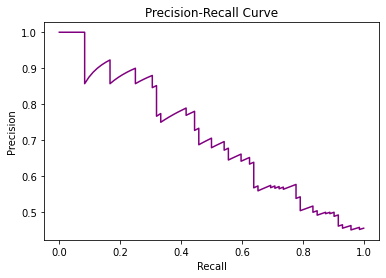

36: Mean accuracy score: 0.602
36: Recall: 0.717


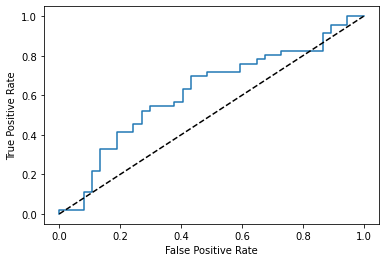

len :  82


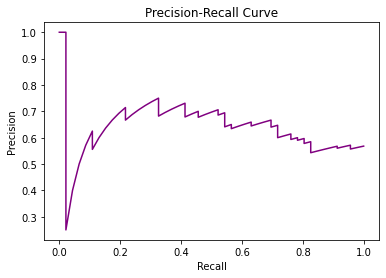

41: Mean accuracy score: 0.677
41: Recall: 0.886


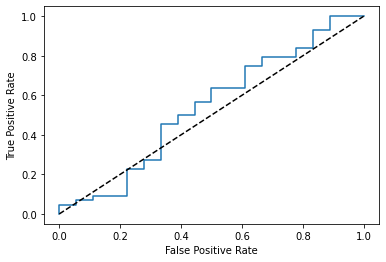

len :  61


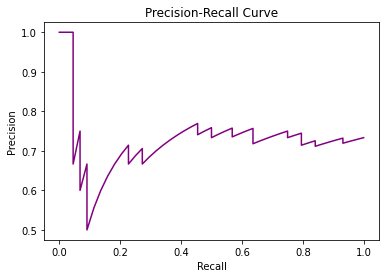

46: Mean accuracy score: 0.809
46: Recall: 0.972


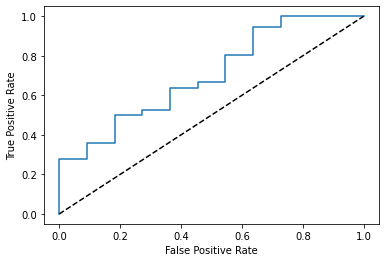

len :  45


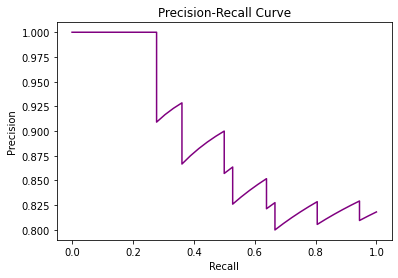

51: Mean accuracy score: 0.846
51: Recall: 1.0


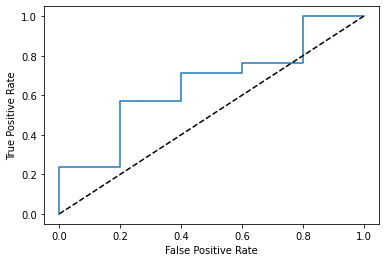

len :  26


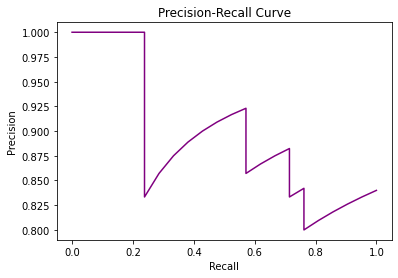

56: Mean accuracy score: 0.75
56: Recall: 0.917


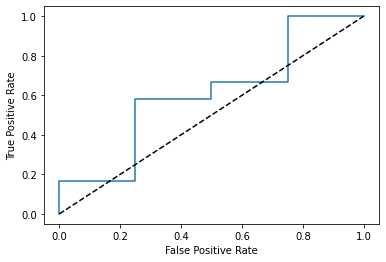

len :  16


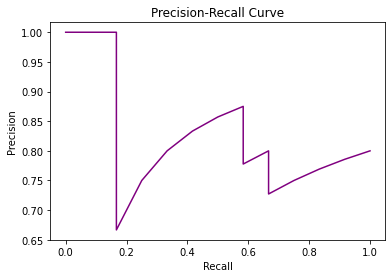

In [94]:

lr_evaluate(clean_test_df_dict_force_simple, models_force_distance)

1
[20:36:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
[20:36:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


11
[20:36:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
16
[20:36:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
21
[20:36:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
26
[20:36:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with t

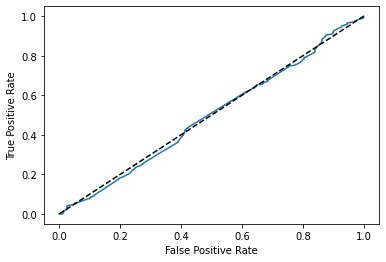

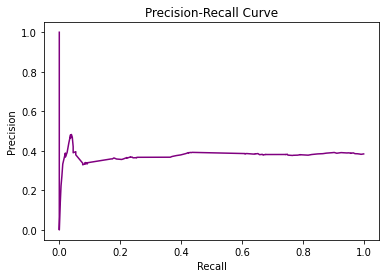

6: Mean accuracy score: 0.626
6: Recall: 0.0


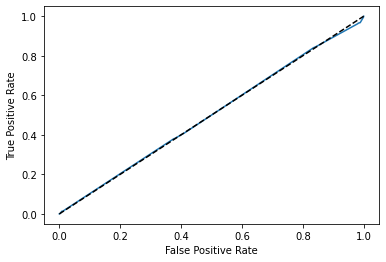

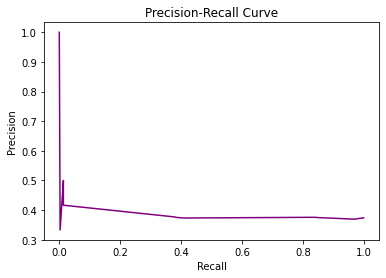

11: Mean accuracy score: 0.622
11: Recall: 0.0


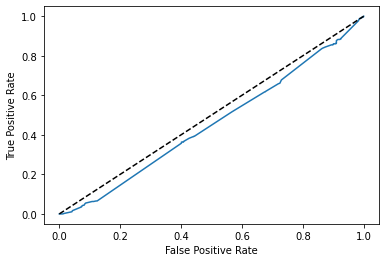

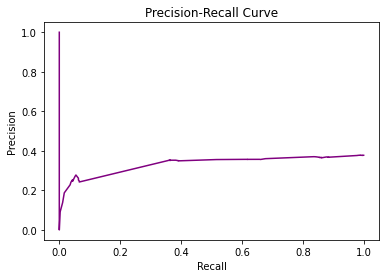

16: Mean accuracy score: 0.62
16: Recall: 0.00301


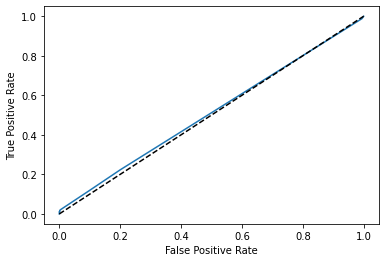

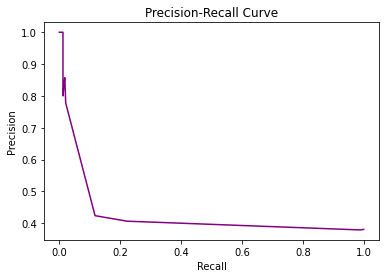

21: Mean accuracy score: 0.611
21: Recall: 0.0


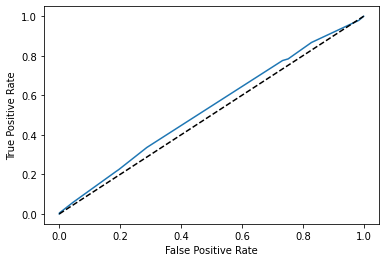

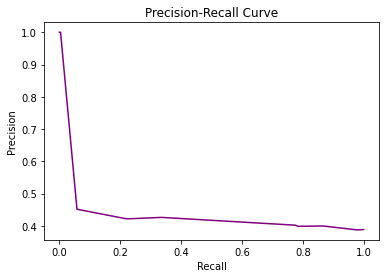

26: Mean accuracy score: 0.621
26: Recall: 0.0165


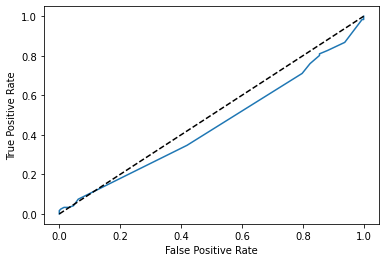

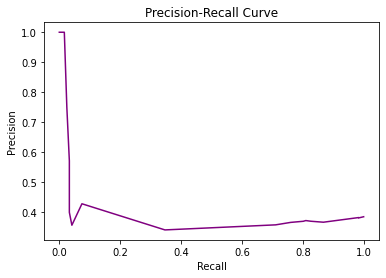

31: Mean accuracy score: 0.544
31: Recall: 0.0


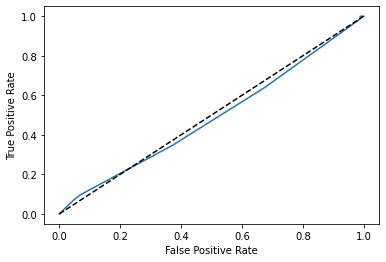

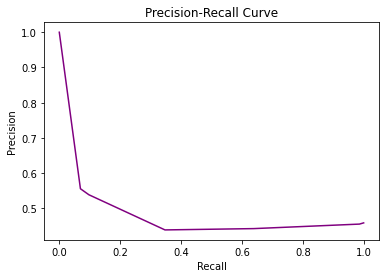

36: Mean accuracy score: 0.446
36: Recall: 0.0


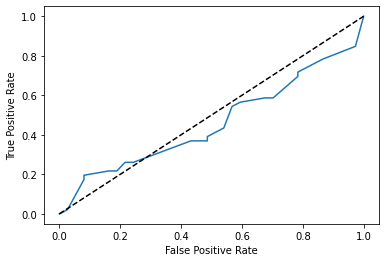

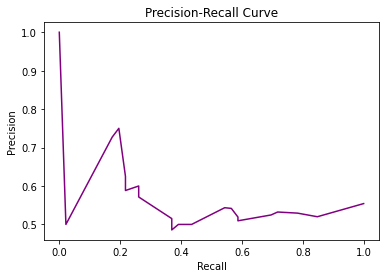

41: Mean accuracy score: 0.323
41: Recall: 0.0909


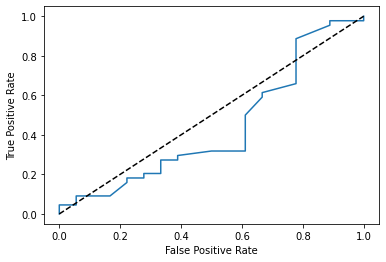

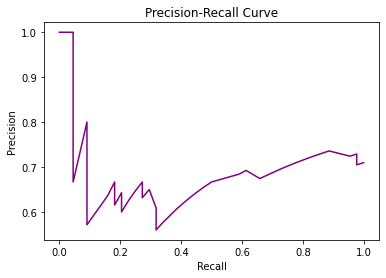

46: Mean accuracy score: 0.362
46: Recall: 0.167


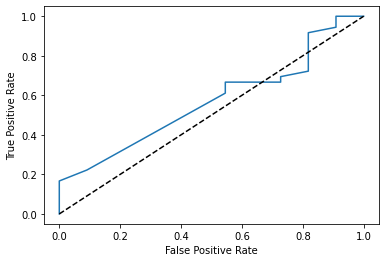

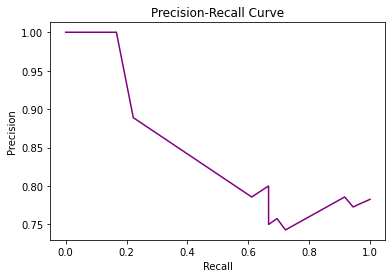

51: Mean accuracy score: 0.615
51: Recall: 0.762


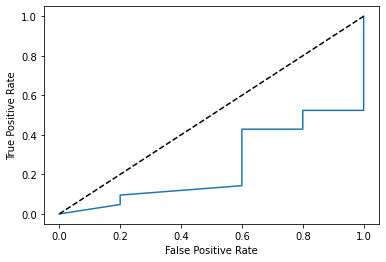

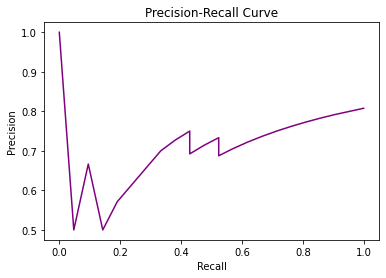

56: Mean accuracy score: 0.188
56: Recall: 0.0


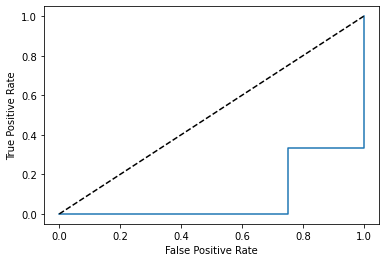

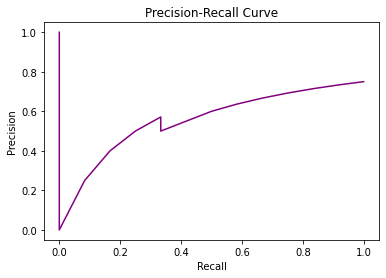

In [85]:
#features = 'distance'

#features = 'force_simple'
#features = 'force_weighted'
features = 'force_partitioned'



clean_train_df_dict = df_split_by_frame(unclean_train_df, features = features)
clean_test_df_dict = df_split_by_frame(unclean_test_df, features = features)

pickle.dump(clean_test_df_dict, open(f"clean_test_dict_{features}.pkl", "wb"))


model3 = train_xgboost_model(clean_train_df_dict)



# pickle.dump(models, open("model_list_all_features.pkl", "wb"))
models_force_partitioned = pickle.load(open("model_list_xgboost_force_partitioned.pkl", "rb"))
clean_test_df_dict_force_simple = pickle.load(open("clean_test_dict_force_partitioned.pkl", "rb"))
models_force_dist = pickle.load(open("model_list_xgboost_force_partitioned.pkl", "rb"))

rf_xgboost_evaluate(clean_test_df_dict_dist, model3,True)